Creado por: Miguel Angel Palomino

#Librerias


In [ ]:
!pip install category_encoders mlflow pyngrok


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
import subprocess
from pyngrok import ngrok, conf
import getpass

from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, recall_score, precision_score

from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError

In [ ]:
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", "sqlite:///mlflow.db"])

mlflow.set_tracking_uri("sqlite:///mlflow.db")
# mlflow will create an experiment if it doesn't exist
mlflow.set_experiment("duration-prediction-experiment")


2025/09/19 19:12:45 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/09/19 19:12:45 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/content/mlruns/1', creation_time=1758287509464, experiment_id='1', last_update_time=1758287509464, lifecycle_stage='active', name='duration-prediction-experiment', tags={}>

In [ ]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
conf.get_default().auth_token = getpass.getpass()
port=5000
public_url = ngrok.connect(port).public_url
print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\"")

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth
··········
 * ngrok tunnel "https://44332d86b630.ngrok-free.app" -> "http://127.0.0.1:5000"


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
df = pd.read_parquet("/content/drive/MyDrive/dataset")

#EDA


In [ ]:
df.head()

,cliente_id,pais_cd,region_comercial_txt,agencia_id,ruta_id,tipo_cliente_cd,madurez_digital_cd,estrellas_txt,frecuencia_visitas_cd,fecha_pedido_dt,canal_pedido_cd,facturacion_usd_val,materiales_distintos_val,cajas_fisicas
0,C125500,EC,COSTA,EC-COS-A003,EC-COS-A003-R002,MINIMARKET,BAJA,1,L,2023-10-04,TELEFONO,141.59,6,11.62
1,C009622,GT,METROPOLITANA,GT-MET-A003,GT-MET-A003-R014,MINIMARKET,ALTA,2,LMV,2023-03-20,DIGITAL,86.03,11,14.74
2,C115462,EC,SIERRA,EC-SIE-A005,EC-SIE-A005-R004,TIENDA,ALTA,3,LMI,2023-11-09,VENDEDOR,143.49,7,17.34
3,C057515,PE,SELVA,PE-SEL-A001,PE-SEL-A001-R011,TIENDA,BAJA,1,LM,2023-11-28,DIGITAL,43.94,4,17.15
4,C143306,SV,OCCIDENTE,SV-OCC-A006,SV-OCC-A006-R014,MINIMARKET,BAJA,3,LMV,2023-04-04,DIGITAL,184.35,10,23.46


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250000 entries, 0 to 1249999
Data columns (total 14 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   cliente_id                1250000 non-null  object        
 1   pais_cd                   1250000 non-null  object        
 2   region_comercial_txt      1250000 non-null  object        
 3   agencia_id                1250000 non-null  object        
 4   ruta_id                   1250000 non-null  object        
 5   tipo_cliente_cd           1250000 non-null  object        
 6   madurez_digital_cd        1250000 non-null  object        
 7   estrellas_txt             1250000 non-null  object        
 8   frecuencia_visitas_cd     1250000 non-null  object        
 9   fecha_pedido_dt           1250000 non-null  datetime64[ns]
 10  canal_pedido_cd           1250000 non-null  object        
 11  facturacion_usd_val       1250000 non-null  float6

In [ ]:
cuenta_unicos = df.nunique()
print(cuenta_unicos)


cliente_id                  149960
pais_cd                          4
region_comercial_txt            11
agencia_id                     116
ruta_id                       1598
tipo_cliente_cd                  3
madurez_digital_cd               3
estrellas_txt                    3
frecuencia_visitas_cd            4
fecha_pedido_dt                601
canal_pedido_cd                  3
facturacion_usd_val          27995
materiales_distintos_val        14
cajas_fisicas                 3128
dtype: int64


- Crear nuevas features que pueden ser más útiles para el entrenamiento (RFM)
- Agrupación por cliente_id: Se conservan las columnas de la 1 a la 9. Agregacion
- División train_test basado en las fechas de los pedidos, por ejemplo train primeros n meses, test ultimos n meses (O años). Regla 80%-20%

In [ ]:
# Contar registros por cliente
clientes_conteo = df.groupby("cliente_id").size().reset_index(name="num_registros")

# Filtrar los que tienen 2 o más registros
clientes_repetidos = clientes_conteo[clientes_conteo["num_registros"] >= 2]

print(clientes_repetidos.head())
print(f"Total clientes con 2+ registros: {len(clientes_repetidos)}")


  cliente_id  num_registros
0    C000001             10
1    C000002              4
2    C000003             10
3    C000004              9
4    C000005             11
Total clientes con 2+ registros: 149655


In [ ]:
clientes_ids = clientes_repetidos["cliente_id"]

df_repetidos = df[df["cliente_id"].isin(clientes_ids)]

# Muestra algunos ejemplos
df_repetidos.sort_values("cliente_id").head()

,cliente_id,pais_cd,region_comercial_txt,agencia_id,ruta_id,tipo_cliente_cd,madurez_digital_cd,estrellas_txt,frecuencia_visitas_cd,fecha_pedido_dt,canal_pedido_cd,facturacion_usd_val,materiales_distintos_val,cajas_fisicas
1193970,C000001,SV,ORIENTE,SV-ORI-A002,SV-ORI-A002-R012,MINIMARKET,ALTA,2,LMV,2024-01-08,DIGITAL,132.85,7,25.26
522102,C000001,SV,ORIENTE,SV-ORI-A002,SV-ORI-A002-R012,MINIMARKET,ALTA,2,LMV,2023-01-22,DIGITAL,56.97,4,11.15
581435,C000001,SV,ORIENTE,SV-ORI-A002,SV-ORI-A002-R012,MINIMARKET,ALTA,2,LMV,2023-10-26,DIGITAL,136.36,14,12.77
1035939,C000001,SV,ORIENTE,SV-ORI-A002,SV-ORI-A002-R012,MINIMARKET,ALTA,2,LMV,2024-03-06,DIGITAL,128.08,3,14.62
316704,C000001,SV,ORIENTE,SV-ORI-A002,SV-ORI-A002-R012,MINIMARKET,ALTA,2,LMV,2024-06-20,DIGITAL,112.24,11,12.46


## Gráficos


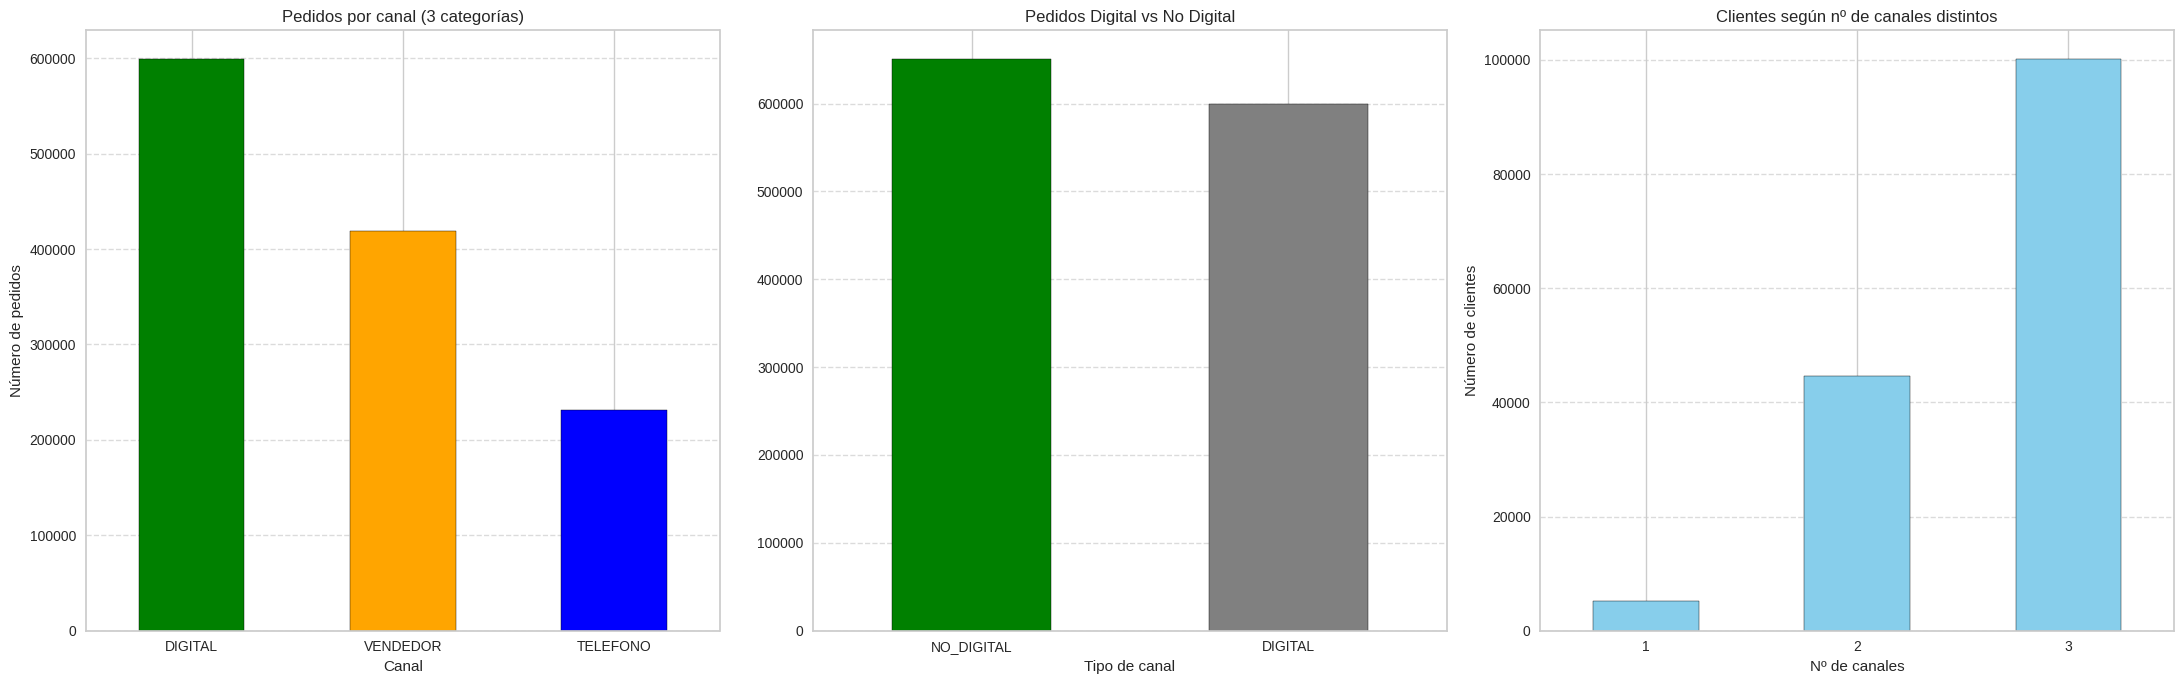

In [ ]:
import matplotlib.pyplot as plt

# --- Datos base ---
# 1. Pedidos por canal (3 categorías)
pedidos_por_canal = df["canal_pedido_cd"].value_counts()

# 2. Pedidos Digital vs No Digital
df["canal_binario"] = df["canal_pedido_cd"].apply(lambda x: "DIGITAL" if x=="DIGITAL" else "NO_DIGITAL")
pedidos_digital_vs_no = df["canal_binario"].value_counts()

# 3. Número de canales distintos por cliente
canales_por_cliente = df.groupby("cliente_id")["canal_pedido_cd"].nunique()
clientes_por_canales = canales_por_cliente.value_counts().sort_index()

# --- Gráficos en una sola figura ---
fig, axes = plt.subplots(1, 3, figsize=(22,7))

# Gráfico 1: pedidos por canal
pedidos_por_canal.plot(
    kind="bar",
    color=["green","orange","blue"],
    edgecolor="black",
    ax=axes[0]
)
axes[0].set_title("Pedidos por canal (3 categorías)")
axes[0].set_xlabel("Canal")
axes[0].set_ylabel("Número de pedidos")
axes[0].set_xticklabels(pedidos_por_canal.index, rotation=0)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Gráfico 2: pedidos Digital vs No Digital
pedidos_digital_vs_no.plot(
    kind="bar",
    color=["green","gray"],
    edgecolor="black",
    ax=axes[1]
)
axes[1].set_title("Pedidos Digital vs No Digital")
axes[1].set_xlabel("Tipo de canal")
axes[1].set_xticklabels(pedidos_digital_vs_no.index, rotation=0)
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

# Gráfico 3: clientes por nº de canales distintos
clientes_por_canales.plot(
    kind="bar",
    color="skyblue",
    edgecolor="black",
    ax=axes[2]
)
axes[2].set_title("Clientes según nº de canales distintos")
axes[2].set_xlabel("Nº de canales")
axes[2].set_ylabel("Número de clientes")
axes[2].set_xticklabels(clientes_por_canales.index, rotation=0)
axes[2].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


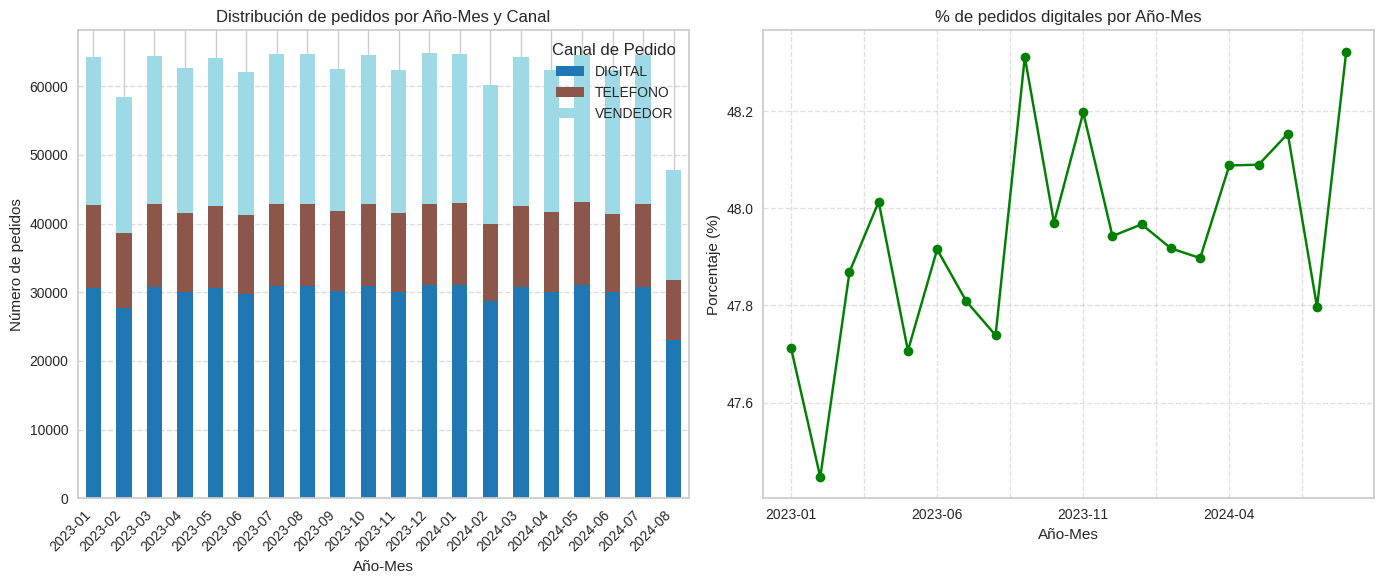

In [ ]:
import matplotlib.pyplot as plt

# Agrupar por año-mes y canal
pedidos_por_mes_canal = (
    df.groupby([df["fecha_pedido_dt"].dt.to_period("M"), "canal_pedido_cd"])
      .size()
      .unstack(fill_value=0)
)

# Convertir índice a string para etiquetas
pedidos_por_mes_canal.index = pedidos_por_mes_canal.index.astype(str)

fig, axes = plt.subplots(1, 2, figsize=(22, 7))

# (Re)calcular la tabla (si quieres mantener tu línea original, pero no es necesario repetir)
pedidos_por_mes_canal = (
    df.groupby([df["fecha_pedido_dt"].dt.to_period("M"), "canal_pedido_cd"])
      .size()
      .unstack(fill_value=0)
)
pedidos_por_mes_canal.index = pedidos_por_mes_canal.index.astype(str)

# Calcular proporción digital (si no existe la columna DIGITAL, crea 0s)
if "DIGITAL" not in pedidos_por_mes_canal.columns:
    pedidos_por_mes_canal["DIGITAL"] = 0

pedidos_por_mes_canal["pct_digital"] = (
    pedidos_por_mes_canal["DIGITAL"] / pedidos_por_mes_canal.sum(axis=1)
) * 100

# Gráfico de barras apiladas
pedidos_por_mes_canal.drop(columns=["pct_digital"]).plot(
    kind="bar",
    stacked=True,
    figsize=(14, 6),
    colormap="tab20",
    ax=axes[0]  # dibujar en axes[0]
)

axes[0].set_title("Distribución de pedidos por Año-Mes y Canal")
axes[0].set_xlabel("Año-Mes")
axes[0].set_ylabel("Número de pedidos")

# Rotación y alineación de etiquetas del eje X (evita el TypeError)
axes[0].tick_params(axis="x", rotation=45)
for label in axes[0].get_xticklabels():
    label.set_ha("right")

axes[0].legend(title="Canal de Pedido")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Gráfico de línea
pedidos_por_mes_canal["pct_digital"].plot(
    kind="line", marker="o", color="green", ax=axes[1]
)

axes[1].set_title("% de pedidos digitales por Año-Mes")
axes[1].set_xlabel("Año-Mes")
axes[1].set_ylabel("Porcentaje (%)")
axes[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()


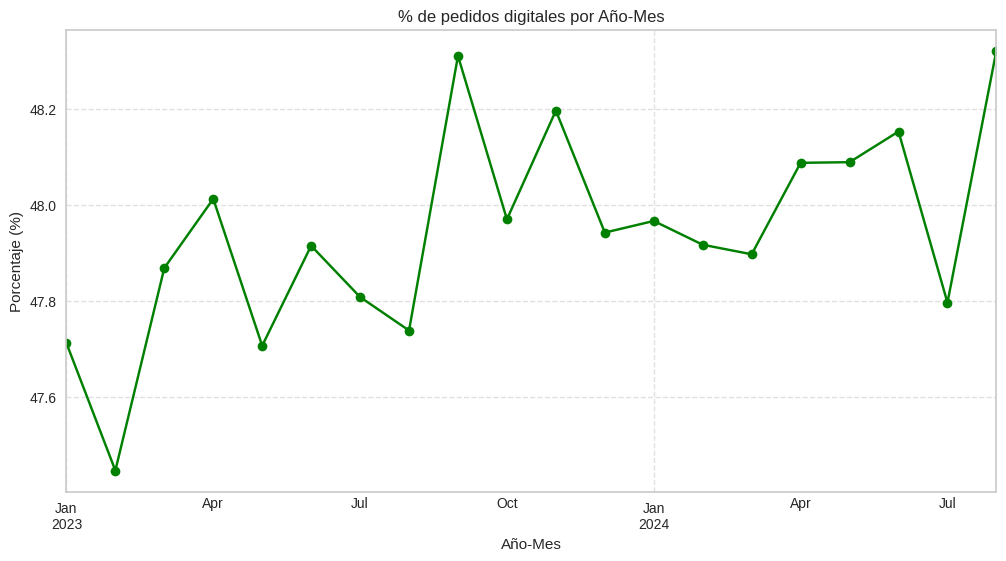

In [ ]:
# % de pedidos digitales por mes
pedidos_por_mes_canal = (
    df.groupby([df["fecha_pedido_dt"].dt.to_period("M"), "canal_pedido_cd"])
      .size()
      .unstack(fill_value=0)
)

# Calcular proporción digital
pedidos_por_mes_canal["pct_digital"] = (
    pedidos_por_mes_canal["DIGITAL"] / pedidos_por_mes_canal.sum(axis=1)
) * 100

# Gráfico de línea
pedidos_por_mes_canal["pct_digital"].plot(
    kind="line", figsize=(12,6), marker="o", color="green"
)

plt.title("% de pedidos digitales por Año-Mes")
plt.xlabel("Año-Mes")
plt.ylabel("Porcentaje (%)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


No hay variaciones fuertes entre meses ni un comportamiento estacional. Seguiremos enfocandonos en las características de los clientes


#Preprocesamiento

##Set train -Set test


In [ ]:
import pandas as pd


df["fecha_pedido_dt"] = pd.to_datetime(df["fecha_pedido_dt"])
df = df.sort_values("fecha_pedido_dt").reset_index(drop=True)
# Calcular la fecha que marca el 80% de los pedidos
fecha_corte = df["fecha_pedido_dt"].quantile(0.8)

print("Fecha de corte para 80/20:", fecha_corte.date())

# Dividir dataset
train = df[df["fecha_pedido_dt"] <= fecha_corte]
test  = df[df["fecha_pedido_dt"] > fecha_corte]

print("Tamaño train:", len(train))
print("Tamaño test:", len(test))
print("Proporción train/test:", len(train)/len(df), len(test)/len(df))


Fecha de corte para 80/20: 2024-04-25
Tamaño train: 1000373
Tamaño test: 249627
Proporción train/test: 0.8002984 0.1997016


In [ ]:
fecha_corte

Timestamp('2024-04-25 00:00:00')

In [ ]:
df.head()

,cliente_id,pais_cd,region_comercial_txt,agencia_id,ruta_id,tipo_cliente_cd,madurez_digital_cd,estrellas_txt,frecuencia_visitas_cd,fecha_pedido_dt,canal_pedido_cd,facturacion_usd_val,materiales_distintos_val,cajas_fisicas,canal_binario
0,C046334,EC,AMAZONIA,EC-AMA-A004,EC-AMA-A004-R006,TIENDA,MEDIA,2,LM,2023-01-01,TELEFONO,71.82,6,8.63,NO_DIGITAL
1,C085084,EC,SIERRA,EC-SIE-A004,EC-SIE-A004-R009,TIENDA,MEDIA,1,LMI,2023-01-01,DIGITAL,74.02,8,26.13,DIGITAL
2,C034806,GT,METROPOLITANA,GT-MET-A006,GT-MET-A006-R002,TIENDA,BAJA,1,L,2023-01-01,VENDEDOR,8.95,3,9.26,NO_DIGITAL
3,C000725,GT,METROPOLITANA,GT-MET-A006,GT-MET-A006-R018,TIENDA,MEDIA,1,LMI,2023-01-01,DIGITAL,118.49,1,13.52,DIGITAL
4,C020962,EC,AMAZONIA,EC-AMA-A005,EC-AMA-A005-R015,MAYORISTA,MEDIA,3,LMI,2023-01-01,VENDEDOR,74.87,12,10.70,NO_DIGITAL


## Funciones


In [ ]:
def agg_historial(hist,
                  col_cliente="cliente_id",
                  col_fecha="fecha_pedido_dt",
                  low_level_cat_snapshot_cols=(
                      "pais_cd","region_comercial_txt","agencia_id","ruta_id",
                      "tipo_cliente_cd","madurez_digital_cd","estrellas_txt","frecuencia_visitas_cd"
                  )):

    #Devuelve un DataFrame con una fila por cliente y features agregadas.


    if hist.empty:
        return pd.DataFrame(columns=[col_cliente])

    hist = hist.copy()
    hist[col_fecha] = pd.to_datetime(hist[col_fecha])
    hist = hist.sort_values([col_cliente, col_fecha])

    # Conteos por canal
    canal_counts = (hist.groupby([col_cliente, "canal_pedido_cd"])
                         .size()
                         .unstack(fill_value=0))
    for c in ["DIGITAL","VENDEDOR","TELEFONO"]:
        if c not in canal_counts.columns:
            canal_counts[c] = 0
    canal_totals = canal_counts.sum(axis=1).rename("n_pedidos")
    pct_digital  = (canal_counts["DIGITAL"] / canal_totals.replace(0, np.nan) * 100).fillna(0).rename("pct_digital_hist")
    n_canales    = (canal_counts > 0).sum(axis=1).rename("n_canales_distintos")
    canal_top    = canal_counts.idxmax(axis=1).rename("canal_mas_frec_hist")
    canal_ult = canal_counts.idxmax(axis=1).map(lambda x: 1 if x == "DIGITAL" else 0).rename("canal_mas_frec_hist")

    # Intervalos entre pedidos
    diffs = (hist.groupby(col_cliente)[col_fecha].diff().dt.days)
    tmp = pd.concat([hist[[col_cliente]], diffs.rename("diff_dias")], axis=1).dropna()
    mean_diff = tmp.groupby(col_cliente)["diff_dias"].mean().rename("dias_prom_entre_pedidos")
    var_diff  = tmp.groupby(col_cliente)["diff_dias"].var().rename("var_entre_pedidos")

    # Agregados monetarios/volumen/diversidad
    aggs = hist.groupby(col_cliente).agg(
        fact_total=("facturacion_usd_val","sum"),
        fact_prom=("facturacion_usd_val","mean"),
        cajas_total=("cajas_fisicas","sum"),
        cajas_prom=("cajas_fisicas","mean"),
        mat_dist_prom=("materiales_distintos_val","mean"),
        fecha_ult=(col_fecha,"max"),
    )

    # Snapshot de categóricas del ÚLTIMO registro del historial
    # (si cambian en el tiempo, tomamos el valor más reciente del hist)
    last_rows = (hist.sort_values([col_cliente, col_fecha])
                    .groupby(col_cliente)
                    .tail(1)
                    [[col_cliente] + list(low_level_cat_snapshot_cols)]
                    .set_index(col_cliente))

    feats = (aggs
             .join([pct_digital, n_canales, canal_ult, canal_totals, mean_diff, var_diff])
             .join(last_rows, how="left")
             .reset_index())

    return feats

In [ ]:
def agg_historial(hist,
                  col_cliente="cliente_id",
                  col_fecha="fecha_pedido_dt",
                  low_level_cat_snapshot_cols=(
                      "pais_cd","region_comercial_txt","agencia_id","ruta_id",
                      "tipo_cliente_cd","madurez_digital_cd","estrellas_txt","frecuencia_visitas_cd"
                  )):
    import numpy as np
    import pandas as pd

    if hist.empty:
        return pd.DataFrame(columns=[col_cliente])

    hist = hist.copy()
    hist[col_fecha] = pd.to_datetime(hist[col_fecha])
    hist = hist.sort_values([col_cliente, col_fecha])

    # Conteos por canal
    canal_counts = (hist.groupby([col_cliente, "canal_pedido_cd"])
                         .size()
                         .unstack(fill_value=0))
    for c in ["DIGITAL","VENDEDOR","TELEFONO"]:
        if c not in canal_counts.columns:
            canal_counts[c] = 0

    canal_totals = canal_counts.sum(axis=1).rename("n_pedidos")
    pct_digital  = (canal_counts["DIGITAL"] / canal_totals.replace(0, np.nan) * 100)\
                    .fillna(0).rename("pct_digital_hist")
    n_canales    = (canal_counts > 0).sum(axis=1).rename("n_canales_distintos")
    canal_top    = canal_counts.idxmax(axis=1).rename("canal_mas_frec_hist")

    # Último canal real (no el más frecuente)
    last_canal = (hist.sort_values([col_cliente, col_fecha])
                     .groupby(col_cliente)
                     .tail(1)
                     .set_index(col_cliente)["canal_pedido_cd"]) \
                     .rename("canal_ult")
    canal_ult_es_digital = (last_canal == "DIGITAL").astype(int).rename("canal_ult_es_digital")

    # Intervalos entre pedidos
    diffs = (hist.groupby(col_cliente)[col_fecha].diff().dt.days)
    tmp = pd.concat([hist[[col_cliente]], diffs.rename("diff_dias")], axis=1).dropna()
    mean_diff = tmp.groupby(col_cliente)["diff_dias"].mean().rename("dias_prom_entre_pedidos")
    var_diff  = tmp.groupby(col_cliente)["diff_dias"].var().rename("var_entre_pedidos")

    # Agregados monetarios/volumen/diversidad
    aggs = hist.groupby(col_cliente).agg(
        fact_total=("facturacion_usd_val","sum"),
        fact_prom=("facturacion_usd_val","mean"),
        cajas_total=("cajas_fisicas","sum"),
        cajas_prom=("cajas_fisicas","mean"),
        mat_dist_prom=("materiales_distintos_val","mean"),
        fecha_ult=(col_fecha,"max"),
    )

    # Snapshot categóricas del último registro
    last_rows = (hist.sort_values([col_cliente, col_fecha])
                    .groupby(col_cliente)
                    .tail(1)
                    [[col_cliente] + list(low_level_cat_snapshot_cols)]
                    .set_index(col_cliente))

    feats = (aggs
             .join([pct_digital, n_canales, canal_totals, mean_diff, var_diff], how="left")
             .join(canal_top, how="left")
             .join(canal_ult_es_digital, how="left")
             .join(last_rows, how="left")
             .reset_index())

    return feats


In [ ]:
def split_xy(train_df, test_df, target_col="canal_ult_hist"):
    """
    Separa X_train, y_train, X_test, y_test a partir de dataframes ya agregados.

    Args:
        train_df (pd.DataFrame): dataset de entrenamiento agregado por cliente.
        test_df (pd.DataFrame): dataset de test agregado por cliente.
        target_col (str): nombre de la columna objetivo.

    Returns:
        X_train, y_train, X_test, y_test
    """
    if target_col not in train_df.columns:
        raise ValueError(f"La columna objetivo '{target_col}' no existe en train_df")
    if target_col not in test_df.columns:
        raise ValueError(f"La columna objetivo '{target_col}' no existe en test_df")

    # Separar features y target
    X_train = train_df.drop(columns=[target_col])
    y_train = train_df[target_col]

    X_test = test_df.drop(columns=[target_col])
    y_test = test_df[target_col]

    print(f"Shapes -> X_train: {X_train.shape}, y_train: {y_train.shape}, "
          f"X_test: {X_test.shape}, y_test: {y_test.shape}")

    return X_train, y_train, X_test, y_test


In [ ]:
def preprocess_for_logreg(
    X_train: pd.DataFrame,
    y_train,
    X_test: pd.DataFrame,
    y_test,
    *,
    low_card_cols: list,     # One-Hot
    high_card_cols: list,    # Target Encoding
    numeric_cols: list,      # a escalar
    drop_cols: list = None   # columnas a eliminar
):
    # Copias
    Xtr = X_train.copy()
    Xte = X_test.copy()
    ytr = pd.Series(y_train).copy()
    yte = pd.Series(y_test).copy()

   #Redundancia
    if ytr.dtype == "O":
        ytr = (ytr.astype(str) == "DIGITAL").astype(int)
        yte = (yte.astype(str) == "DIGITAL").astype(int)
    else:
        ytr = ytr.astype(int)
        yte = yte.astype(int)

    # 1) Eliminar columnas no-modelables
    drop_cols = drop_cols or []
    to_drop = [c for c in drop_cols if c in Xtr.columns]
    if to_drop:
        Xtr = Xtr.drop(columns=to_drop)
        Xte = Xte.drop(columns=to_drop)


    num_cols  = [c for c in numeric_cols   if c in Xtr.columns]
    low_cols  = [c for c in low_card_cols  if c in Xtr.columns]
    high_cols = [c for c in high_card_cols if c in Xtr.columns]

    # 3) Imputación numérica nulos
    scaler = None
    if len(num_cols):
        num_tr = Xtr[num_cols].copy()
        num_te = Xte[num_cols].copy()

        # Imputación con mediana de train
        med = num_tr.median().to_dict()
        num_tr = num_tr.fillna(med)
        num_te = num_te.fillna(med)
        # Escalado
        scaler = StandardScaler().fit(num_tr)
        num_tr_s = pd.DataFrame(scaler.transform(num_tr), columns=num_cols, index=Xtr.index)
        num_te_s = pd.DataFrame(scaler.transform(num_te), columns=num_cols, index=Xte.index)
    else:
        num_tr_s = pd.DataFrame(index=Xtr.index)
        num_te_s = pd.DataFrame(index=Xte.index)

    #  One-Hot (baja cardinalidad)
    ohe_tr = pd.get_dummies(Xtr[low_cols].astype(str).fillna("UNK"), drop_first=False) if len(low_cols) else pd.DataFrame(index=Xtr.index)
    ohe_te = pd.get_dummies(Xte[low_cols].astype(str).fillna("UNK"), drop_first=False) if len(low_cols) else pd.DataFrame(index=Xte.index)
    # Alinear columnas del test a las del train
    ohe_te = ohe_te.reindex(columns=ohe_tr.columns, fill_value=0)

    # Target Encoding (alta cardinalidad)
    if len(high_cols):
        te = TargetEncoder(cols=high_cols, handle_missing="value", handle_unknown="value")
        te_tr = te.fit_transform(Xtr[high_cols].astype(str), ytr)
        te_te = te.transform(Xte[high_cols].astype(str))
    else:
        te = None
        te_tr = pd.DataFrame(index=Xtr.index)
        te_te = pd.DataFrame(index=Xte.index)

    #  Concatenar bloques en el mismo orden
    Xtr_proc = pd.concat([num_tr_s, ohe_tr, te_tr], axis=1)
    Xte_proc = pd.concat([num_te_s, ohe_te, te_te], axis=1)

    artifacts = {
        "scaler": scaler,
        "target_encoder": te,
        "columns_used": {
            "numeric": num_cols,
            "one_hot_from": low_cols,
            "one_hot_columns_": list(ohe_tr.columns),
            "target_encoded": high_cols
        }
    }
    return Xtr_proc, ytr, Xte_proc, yte, artifacts


## Procesamiento

In [ ]:
df_agg_train= agg_historial(train)
df_agg_test= agg_historial(test)
pd.set_option('display.max_columns', None)
df_agg_train.head(5)

,cliente_id,fact_total,fact_prom,cajas_total,cajas_prom,mat_dist_prom,fecha_ult,pct_digital_hist,n_canales_distintos,n_pedidos,dias_prom_entre_pedidos,var_entre_pedidos,canal_mas_frec_hist,canal_ult_es_digital,pais_cd,region_comercial_txt,agencia_id,ruta_id,tipo_cliente_cd,madurez_digital_cd,estrellas_txt,frecuencia_visitas_cd
0,C000001,897.33,128.190000,100.90,14.414286,7.714286,2024-03-16,100.000000,1,7,69.833333,2144.166667,DIGITAL,1,SV,ORIENTE,SV-ORI-A002,SV-ORI-A002-R012,MINIMARKET,ALTA,2,LMV
1,C000002,340.07,113.356667,39.33,13.110000,4.333333,2023-08-15,33.333333,2,3,76.500000,3280.500000,TELEFONO,1,SV,OCCIDENTE,SV-OCC-A009,SV-OCC-A009-R014,TIENDA,BAJA,1,L
2,C000003,1060.77,117.863333,108.71,12.078889,9.888889,2024-04-22,77.777778,2,9,55.625000,3242.267857,DIGITAL,1,GT,OCCIDENTE,GT-OCC-A007,GT-OCC-A007-R018,TIENDA,ALTA,3,LM
3,C000004,913.62,130.517143,93.50,13.357143,8.285714,2024-04-02,71.428571,2,7,73.000000,4052.800000,DIGITAL,1,PE,SUR,PE-SUR-A010,PE-SUR-A010-R008,TIENDA,BAJA,1,LM
4,C000005,853.67,106.708750,81.74,10.217500,9.375000,2023-11-10,50.000000,3,8,31.000000,655.333333,DIGITAL,1,GT,NORTE,GT-NOR-A001,GT-NOR-A001-R004,MAYORISTA,MEDIA,2,LM


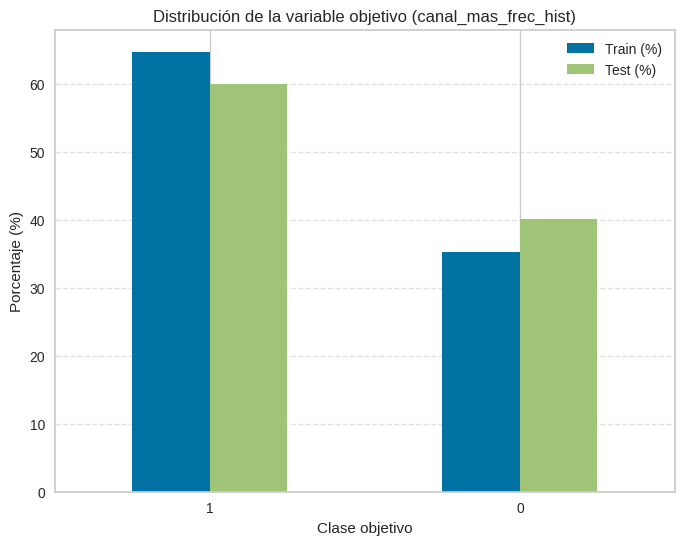

Distribución en Train (abs):
canal_mas_frec_hist
1    96904
0    52901
Name: count, dtype: int64

Distribución en Test (abs):
canal_mas_frec_hist
1    72990
0    48778
Name: count, dtype: int64


In [ ]:
# Conteos por clase en cada dataset
train_counts = df_agg_train["canal_mas_frec_hist"].value_counts(normalize=True) * 100
test_counts  = df_agg_test["canal_mas_frec_hist"].value_counts(normalize=True) * 100

# Unir en un solo DataFrame para facilidad de graficar
dist_df = (
    pd.DataFrame({
        "Train (%)": train_counts,
        "Test (%)": test_counts
    })
    .fillna(0)
)

# Gráfico de barras lado a lado
dist_df.plot(kind="bar", figsize=(8,6))
plt.title("Distribución de la variable objetivo )")
plt.ylabel("Porcentaje (%)")
plt.xlabel("Clase objetivo")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(loc="best")
plt.show()

# También puedes imprimir los números absolutos si lo deseas
print("Distribución en Train (abs):")
print(df_agg_train["canal_mas_frec_hist"].value_counts())
print("\nDistribución en Test (abs):")
print(df_agg_test["canal_mas_frec_hist"].value_counts())


In [ ]:
print("Train ->", df_agg_train.shape[0], "registros")
print("Test  ->", df_agg_test.shape[0], "registros")


Train -> 149805 registros
Test  -> 121768 registros


In [ ]:
X_train, y_train, X_test, y_test = split_xy(df_agg_train, df_agg_test, target_col="canal_mas_frec_hist")


Shapes -> X_train: (149805, 21), y_train: (149805,), X_test: (121768, 21), y_test: (121768,)


In [ ]:
low_card_cols  = [ "pais_cd", "region_comercial_txt",
                  "tipo_cliente_cd", "madurez_digital_cd", "estrellas_txt", "frecuencia_visitas_cd"]
high_card_cols = ["agencia_id", "ruta_id"]
numeric_cols   = ["fact_total","fact_prom","cajas_total","cajas_prom","mat_dist_prom","pct_digital_hist"
                  ,"n_canales_distintos","n_pedidos",
                  "dias_prom_entre_pedidos","var_entre_pedidos"]

# Columnas a eliminar
drop_cols = ["cliente_id", "fecha_ult"]

X_train, y_train, X_test, y_test, arts = preprocess_for_logreg(
    X_train, y_train, X_test, y_test,
    low_card_cols=low_card_cols,
    high_card_cols=high_card_cols,
    numeric_cols=numeric_cols,
    drop_cols=drop_cols)


### Data leakage

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Entrenar modelo de Regresión Logística
lr = LogisticRegression(max_iter=1000, random_state=69)
lr.fit(X_train, y_train)

# Predicciones en test
y_pred = lr.predict(X_test)

# Métricas
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy en Test: {acc:.4f}\n")
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))


Accuracy en Test: 0.9971

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     48778
           1       1.00      1.00      1.00     72990

    accuracy                           1.00    121768
   macro avg       1.00      1.00      1.00    121768
weighted avg       1.00      1.00      1.00    121768



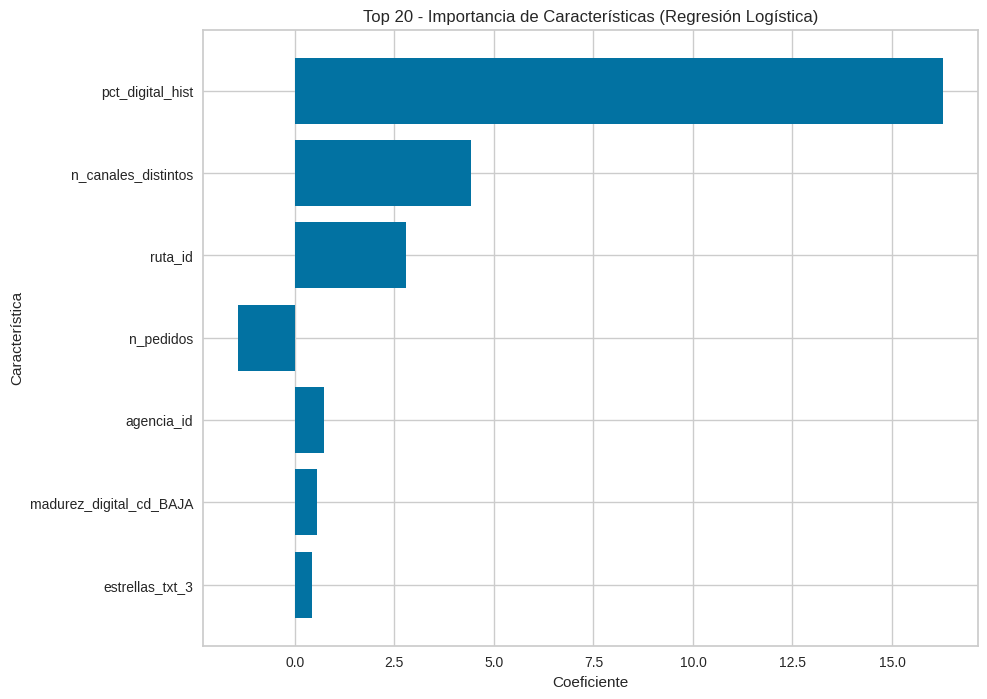

In [ ]:
# Coeficientes del modelo
coefficients = lr.coef_[0]
features = X_train.columns

# Crear DataFrame con coeficientes
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

# Ordenar por valor absoluto
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)

# Graficar top 7
plt.figure(figsize=(10, 8))
plt.barh(coef_df['Feature'].head(7), coef_df['Coefficient'].head(7))
plt.xlabel('Coeficiente')
plt.ylabel('Característica')
plt.title('Top 20 - Importancia de Características (Regresión Logística)')
plt.gca().invert_yaxis()
plt.show()


Columna nueva que proviene directamente de la variable objetivo, correlación del 80%

### Prevenir leakage

In [ ]:
cols_to_drop = ["pct_digital_hist","ruta_id","agencia_id"]
X_train = X_train.drop(columns=cols_to_drop)
X_test  = X_test.drop(columns=cols_to_drop)
pd.set_option('display.max_columns', None)
X_train.head()


,fact_total,fact_prom,cajas_total,cajas_prom,mat_dist_prom,n_canales_distintos,n_pedidos,dias_prom_entre_pedidos,var_entre_pedidos,pais_cd_EC,pais_cd_GT,pais_cd_PE,pais_cd_SV,region_comercial_txt_AMAZONIA,region_comercial_txt_CENTRO,region_comercial_txt_COSTA,region_comercial_txt_LIMA,region_comercial_txt_METROPOLITANA,region_comercial_txt_NORTE,region_comercial_txt_OCCIDENTE,region_comercial_txt_ORIENTE,region_comercial_txt_SELVA,region_comercial_txt_SIERRA,region_comercial_txt_SUR,tipo_cliente_cd_MAYORISTA,tipo_cliente_cd_MINIMARKET,tipo_cliente_cd_TIENDA,madurez_digital_cd_ALTA,madurez_digital_cd_BAJA,madurez_digital_cd_MEDIA,estrellas_txt_1,estrellas_txt_2,estrellas_txt_3,frecuencia_visitas_cd_L,frecuencia_visitas_cd_LM,frecuencia_visitas_cd_LMI,frecuencia_visitas_cd_LMV
0,0.279924,0.369855,0.615958,1.127688,0.124170,-2.418309,0.125344,-0.001075,-0.343825,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,True
1,-1.386986,-0.332452,-1.227066,0.510408,-1.836031,-0.799645,-1.430928,0.172753,-0.155901,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,True,False,True,False,False,True,False,False,False
2,0.768816,-0.119077,0.849741,0.022412,1.384957,-0.799645,0.903480,-0.371544,-0.162224,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False,True,False,True,False,False
3,0.328651,0.480037,0.394448,0.627373,0.455472,-0.799645,0.125344,0.081493,-0.028179,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,True,False,False,False,True,False,False
4,0.149325,-0.647207,0.042427,-0.858529,1.087016,0.819019,0.514412,-1.013619,-0.590046,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,True,False,False


### Matriz de correlacion

In [ ]:
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

In [ ]:
df_full = X_full.copy()
df_full["target"] = y_full

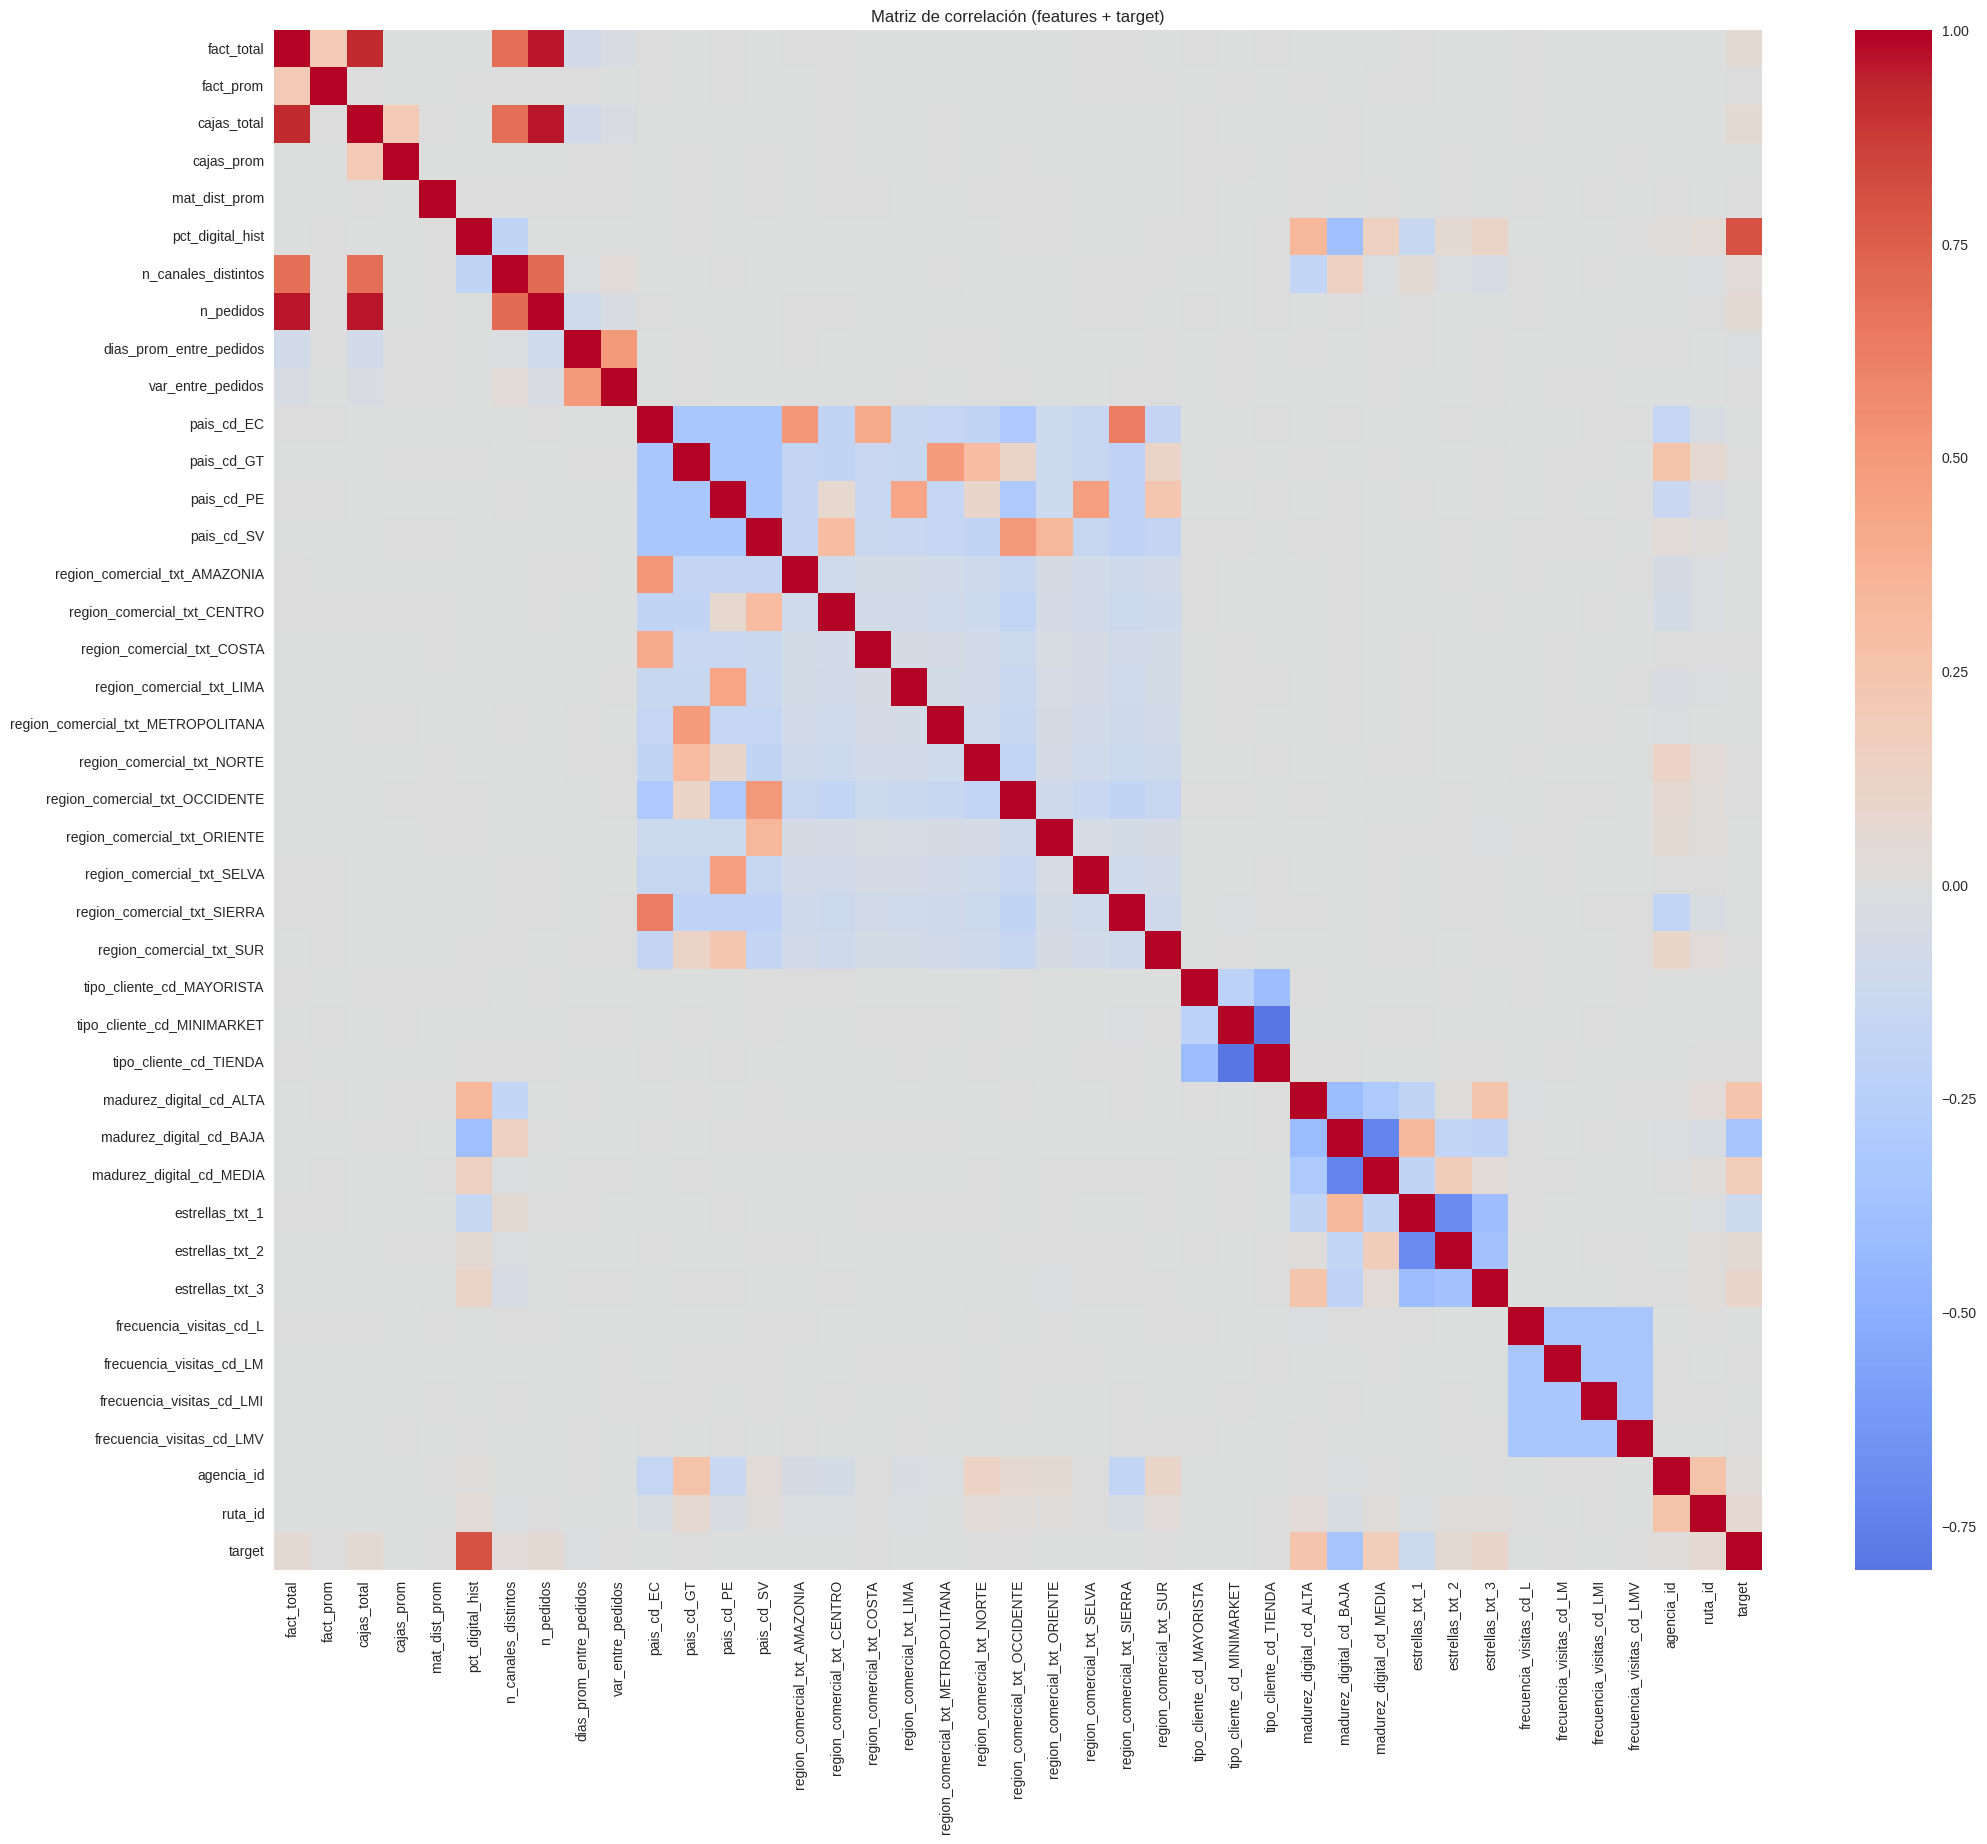

In [ ]:
corr_matrix = df_full.corr()

# Ver correlación de cada variable con el target
corr_target = corr_matrix["target"].sort_values(ascending=False)
plt.figure(figsize=(24,20))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Matriz de correlación (features + target)")
plt.show()

#Entrenamiento


## Regresión logística


In [ ]:
cols_to_drop = ["agencia_id"]
X_train = X_train.drop(columns=cols_to_drop)
X_test  = X_test.drop(columns=cols_to_drop)


Matriz de Confusión:
[[32850 15928]
 [28123 44867]]


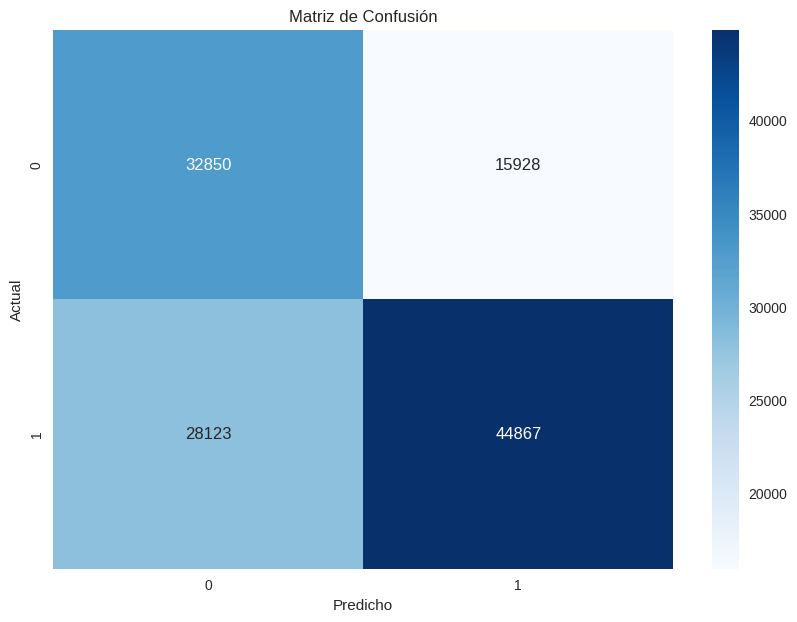

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.54      0.67      0.60     48778
           1       0.74      0.61      0.67     72990

    accuracy                           0.64    121768
   macro avg       0.64      0.64      0.63    121768
weighted avg       0.66      0.64      0.64    121768



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

import mlflow
mlflow.set_experiment("ClasificacionBinaria")
with mlflow.start_run():
  params = dict(
          solver="lbfgs",
          max_iter= 1000,
          random_state= 42,
          penalty="l2"
      )
  mlflow.log_params(params)


  # Entrenamiento del modelo
  lr = LogisticRegression(**params)
  lr.fit(X_train, y_train )

  # Predicción con el modelo
  y_pred = lr.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  y_proba = lr.predict_proba(X_test)
  auc = roc_auc_score(y_test, y_proba[:, 1])

  metrics = {
      "accuracy": accuracy,
      "precision": precision,
      "recall": recall,
      "f1_score": f1,
      "roc_auc": auc
      }
  mlflow.log_metrics(metrics)


  # Generar matriz de confusión
  conf_matrix = confusion_matrix(y_test, y_pred)
  print("Matriz de Confusión:")
  print(conf_matrix)

  # Visualización de la matriz de confusión
  plt.figure(figsize=(10, 7))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
  plt.ylabel('Actual')
  plt.xlabel('Predicho')
  plt.title('Matriz de Confusión')
  plt.show()

  # Generar reporte de clasificación
  class_report = classification_report(y_test, y_pred)
  print("Reporte de Clasificación:")
  print(class_report)

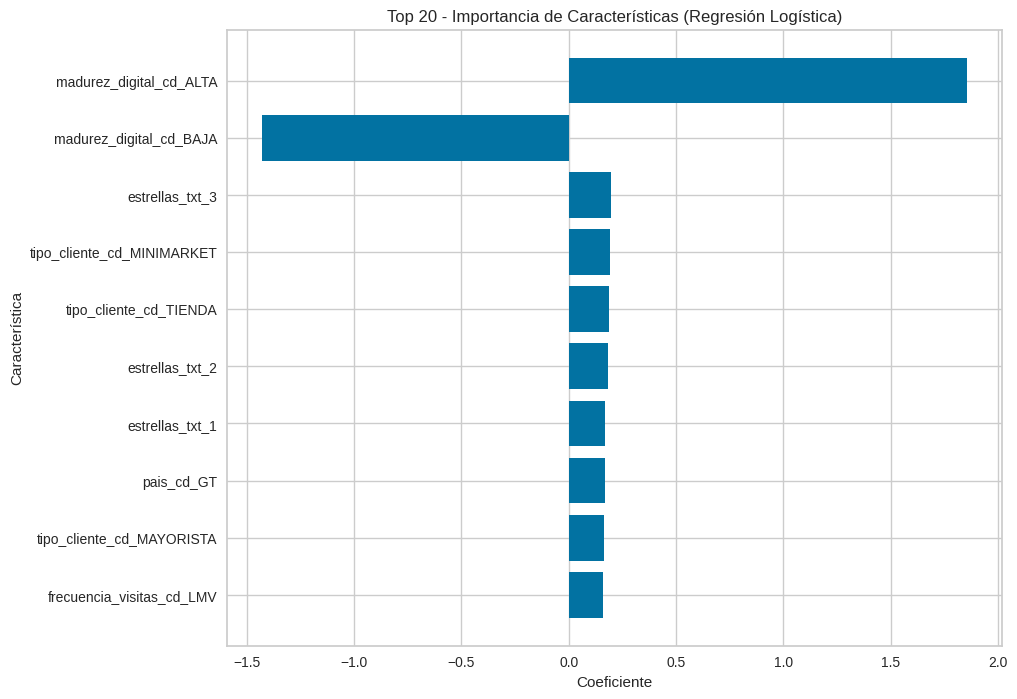

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Coeficientes del modelo
coefficients = lr.coef_[0]        # lr es tu modelo de LogisticRegression ya entrenado
features = X_train.columns        # columnas de tu set preprocesado

# Crear DataFrame con coeficientes
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

# Ordenar por valor absoluto
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)

# Graficar top 10 features más influyentes
plt.figure(figsize=(10, 8))
plt.barh(coef_df['Feature'].head(10), coef_df['Coefficient'].head(10))
plt.xlabel('Coeficiente')
plt.ylabel('Característica')
plt.title('Top 20 - Importancia de Características (Regresión Logística)')
plt.gca().invert_yaxis()
plt.show()


## XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:53:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


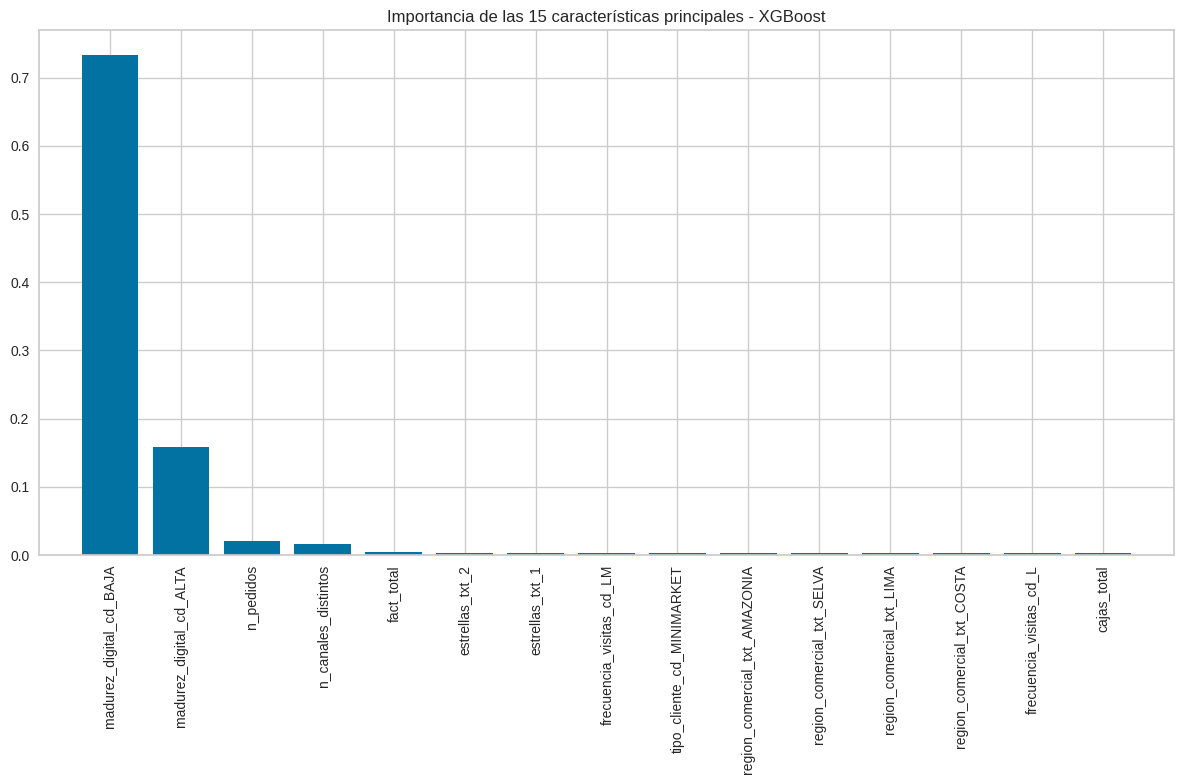

In [ ]:
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt

# Entrenar un modelo de XGBoost
xgb = XGBClassifier(
    n_estimators=200,
    gamma=0,
    learning_rate=0.1,
    max_depth=4,
    random_state=69,
    use_label_encoder=False,
    eval_metric="logloss"
)
xgb.fit(X_train, y_train)

# Importancia de características
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]

# Nombres de las características
feature_names = X_train.columns
sorted_feature_names = [feature_names[i] for i in indices]

# Seleccionar las 15 más importantes
top_n = 15
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_sorted_feature_names = [feature_names[i] for i in top_indices]

# Gráfico
plt.figure(figsize=(12, 8))
plt.title("Importancia de las 15 características principales - XGBoost")
plt.bar(range(top_n), top_importances, align="center")
plt.xticks(range(top_n), top_sorted_feature_names, rotation=90)
plt.xlim([-1, top_n])
plt.tight_layout()
plt.show()


In [ ]:
xgb_predictions = xgb.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

XGBoost Accuracy: 0.6976


In [ ]:
report = classification_report(y_test, xgb_predictions)
print("Reporte de clasificación:")
print(report)

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.63      0.58      0.61     48778
           1       0.74      0.77      0.75     72990

    accuracy                           0.70    121768
   macro avg       0.68      0.68      0.68    121768
weighted avg       0.69      0.70      0.70    121768



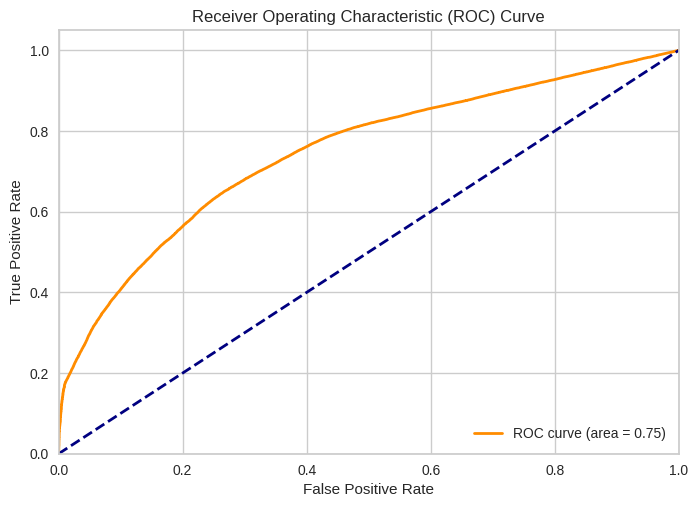

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# Compute the ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Prueba2

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [14:25:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


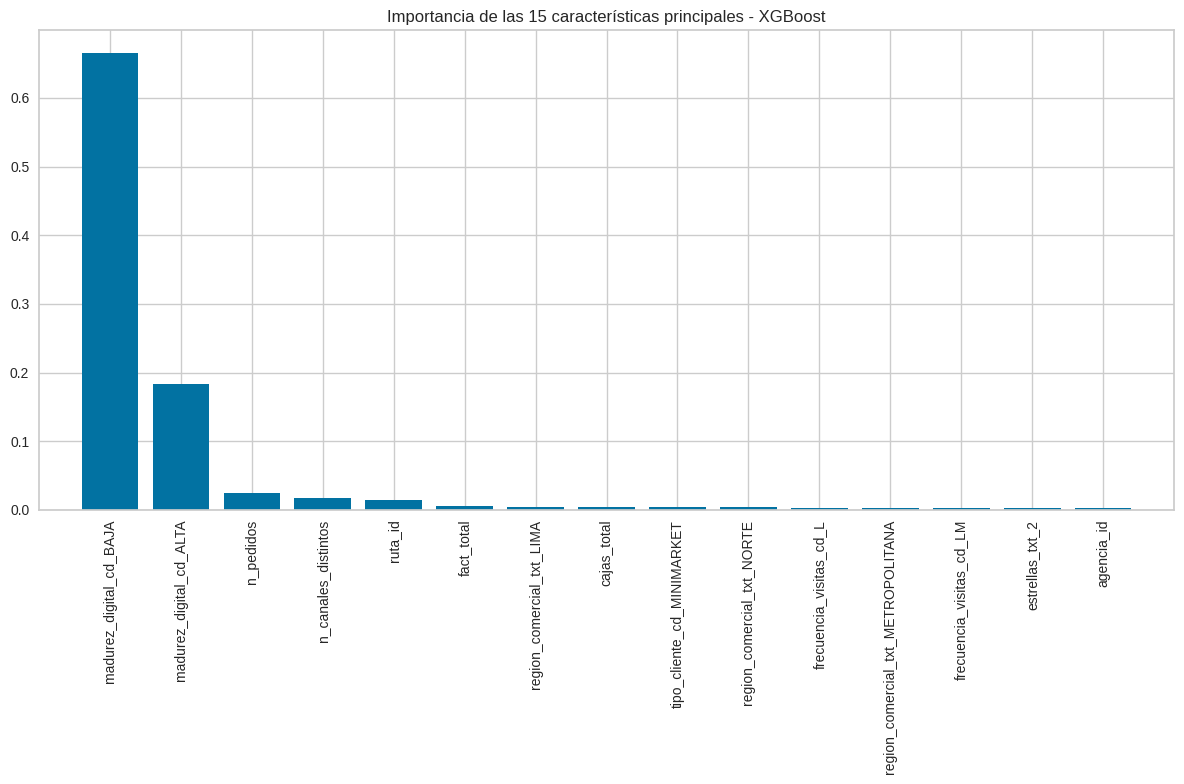

In [ ]:
from xgboost import XGBClassifier
import numpy as np
import matplotlib.pyplot as plt

# Entrenar un modelo de XGBoost
xgb = XGBClassifier(
    n_estimators=200,
    gamma=0,
    learning_rate=0.1,
    max_depth=4,
    random_state=69,
    use_label_encoder=False,
    eval_metric="logloss"
)
xgb.fit(X_train, y_train)

# Importancia de características
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]

# Nombres de las características
feature_names = X_train.columns
sorted_feature_names = [feature_names[i] for i in indices]

# Seleccionar las 15 más importantes
top_n = 15
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_sorted_feature_names = [feature_names[i] for i in top_indices]

# Gráfico
plt.figure(figsize=(12, 8))
plt.title("Importancia de las 15 características principales - XGBoost")
plt.bar(range(top_n), top_importances, align="center")
plt.xticks(range(top_n), top_sorted_feature_names, rotation=90)
plt.xlim([-1, top_n])
plt.tight_layout()
plt.show()


In [ ]:
xgb_predictions = xgb.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

XGBoost Accuracy: 0.6940


In [ ]:
report = classification_report(y_test, xgb_predictions)
print("Reporte de clasificación:")
print(report)

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.63      0.58      0.60     48778
           1       0.73      0.77      0.75     72990

    accuracy                           0.69    121768
   macro avg       0.68      0.67      0.68    121768
weighted avg       0.69      0.69      0.69    121768



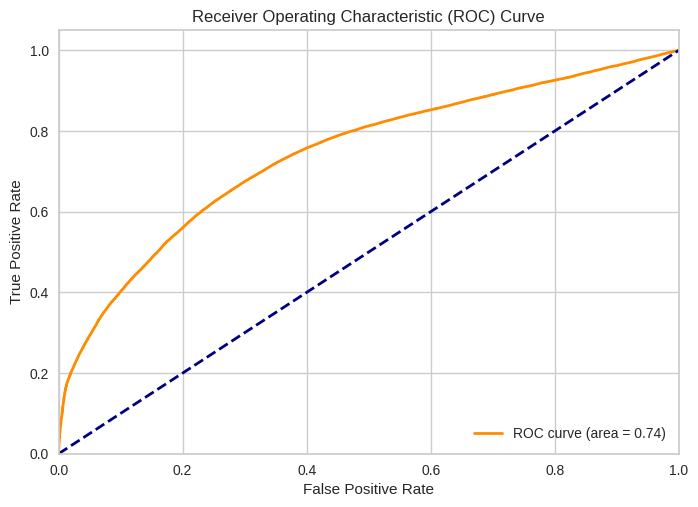

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = xgb.predict_proba(X_test)[:, 1]

# Compute the ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### RandomSearch


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Mejores parámetros: {'subsample': 0.7, 'reg_lambda': 2.0, 'reg_alpha': 0.5, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.9}
Mejor AUC (CV temporal): 0.7091399428586685

AUC (test): 0.7438898627938808
ACC (test): 0.6956918073713948


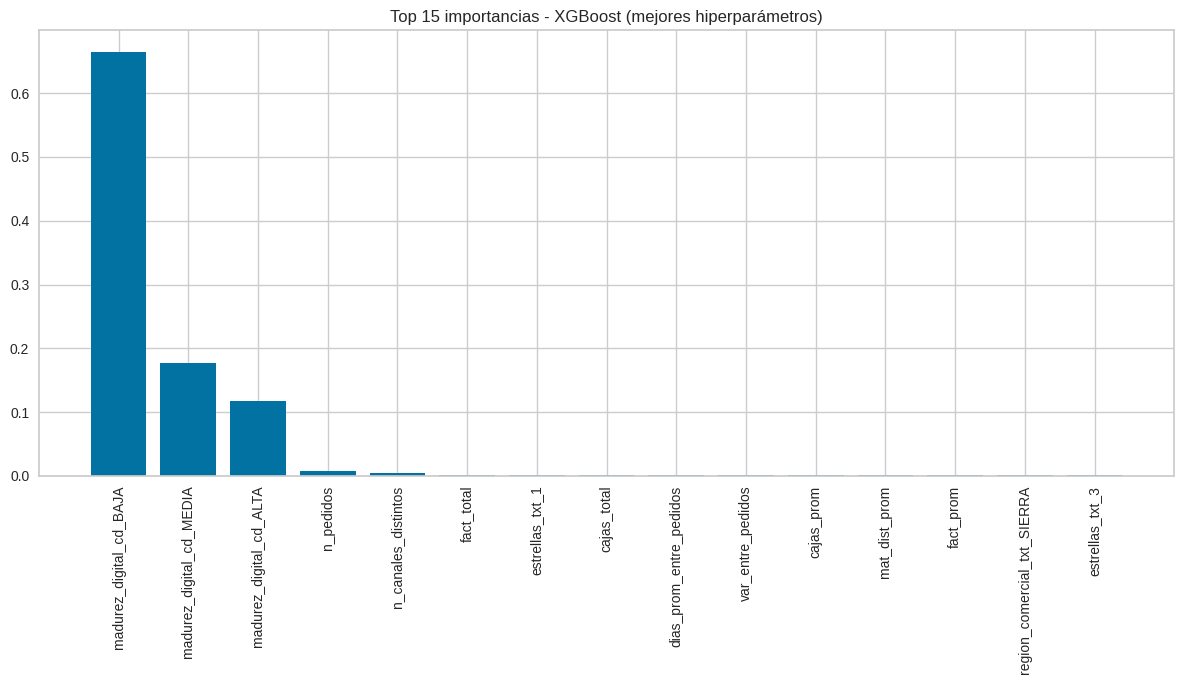

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt


# splitter temporal
tscv = TimeSeriesSplit(n_splits=3)


xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=69,
    tree_method="hist",
    n_jobs=-1
)
#Grid
param_dist = {
    "n_estimators":      [200, 300, 400, 600, 800],
    "max_depth":         [3, 4, 5, 6, 8],
    "learning_rate":     [0.01, 0.03, 0.05, 0.1],
    "subsample":         [0.7, 0.8, 0.9, 1.0],
    "colsample_bytree":  [0.7, 0.8, 0.9, 1.0],
    "min_child_weight":  [1, 3, 5, 7],
    "gamma":             [0, 0.1, 0.2, 0.3],
    "reg_lambda":        [0.5, 1.0, 2.0, 3.0],
    "reg_alpha":         [0.0, 0.1, 0.3, 0.5]
}

rand = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=20,
    scoring="accuracy",
    cv=tscv,                # VALIDACIÓN TEMPORAL
    verbose=2,
    n_jobs=-1,
    random_state=69
)

#Entrenar la búsqueda en TRAIN
rand.fit(X_train, y_train)

print("Mejores parámetros:", rand.best_params_)
print("Mejor AUC (CV temporal):", rand.best_score_)

#odelo final con mejores hiperparámetros
best_xgb = rand.best_estimator_

# Entrenar en TODO el train y evaluar en TEST fijo (futuro)
best_xgb.fit(X_train, y_train)
proba = best_xgb.predict_proba(X_test)[:, 1]
pred  = (proba >= 0.5).astype(int)

print("\nAUC (test):", roc_auc_score(y_test, proba))
print("ACC (test):", accuracy_score(y_test, pred))

 #Importancia de características
importances = best_xgb.feature_importances_
idx = np.argsort(importances)[::-1]
top_n = 15
top_idx = idx[:top_n]
feat_names = X_train.columns

plt.figure(figsize=(12, 7))
plt.title("Top 15 importancias - XGBoost (mejores hiperparámetros)")
plt.bar(range(top_n), importances[top_idx], align="center")
plt.xticks(range(top_n), [feat_names[i] for i in top_idx], rotation=90)
plt.tight_layout()
plt.show()


In [ ]:
!pip install lazypredict --quiet

## Randomforest


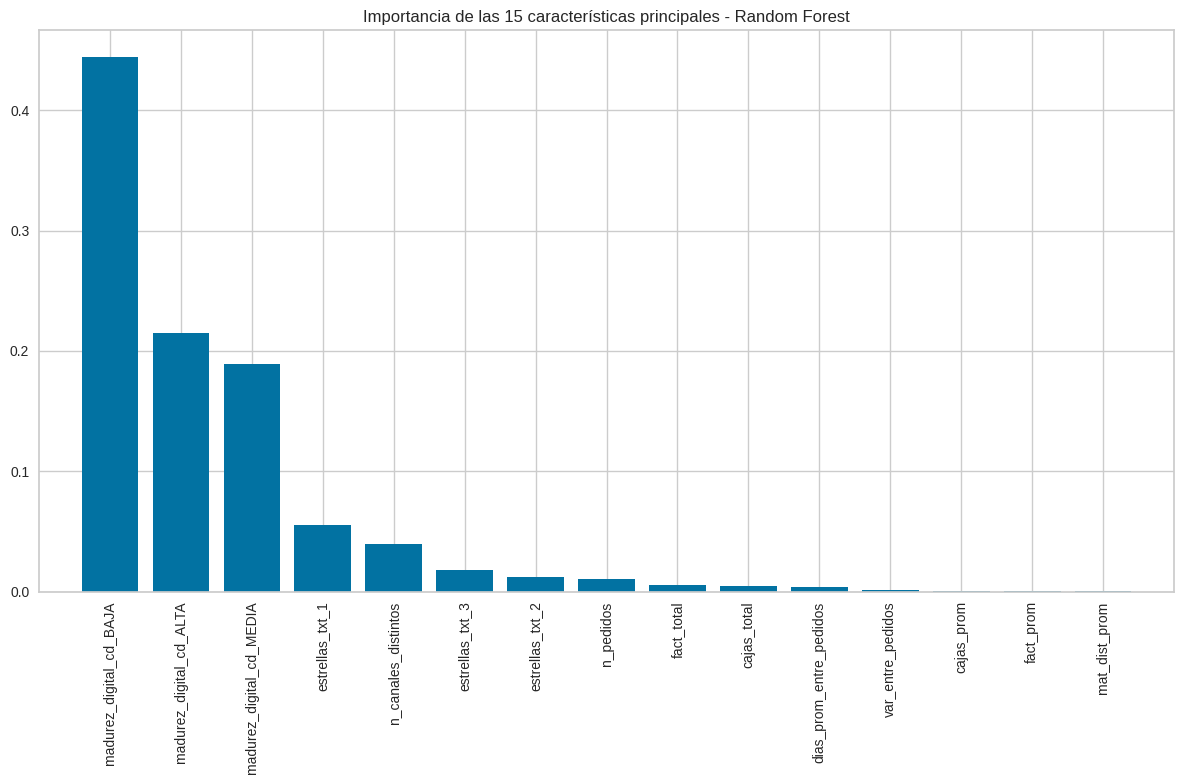

In [ ]:
# Entrenar un modelo de Random Forest
rf = RandomForestClassifier(
    n_estimators=200,   # número de árboles
    max_depth=4,        # profundidad máxima de cada árbol
    random_state=69,
    n_jobs=-1,          # usar todos los núcleos
    criterion="gini"    # también puedes usar "entropy" o "log_loss"
)
rf.fit(X_train, y_train)

# Importancia de características
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Nombres de las características
feature_names = X_train.columns
sorted_feature_names = [feature_names[i] for i in indices]

# Seleccionar las 15 más importantes
top_n = 15
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_sorted_feature_names = [feature_names[i] for i in top_indices]

# Gráfico
plt.figure(figsize=(12, 8))
plt.title("Importancia de las 15 características principales - Random Forest")
plt.bar(range(top_n), top_importances, align="center")
plt.xticks(range(top_n), top_sorted_feature_names, rotation=90)
plt.xlim([-1, top_n])
plt.tight_layout()
plt.show()


In [ ]:
rf_predictions = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"rf Accuracy: {rf_accuracy:.4f}")

rf Accuracy: 0.6596


In [ ]:
report = classification_report(y_test, rf_predictions)
print("Reporte de clasificación:")
print(report)

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.64      0.35      0.45     48778
           1       0.67      0.87      0.75     72990

    accuracy                           0.66    121768
   macro avg       0.65      0.61      0.60    121768
weighted avg       0.65      0.66      0.63    121768



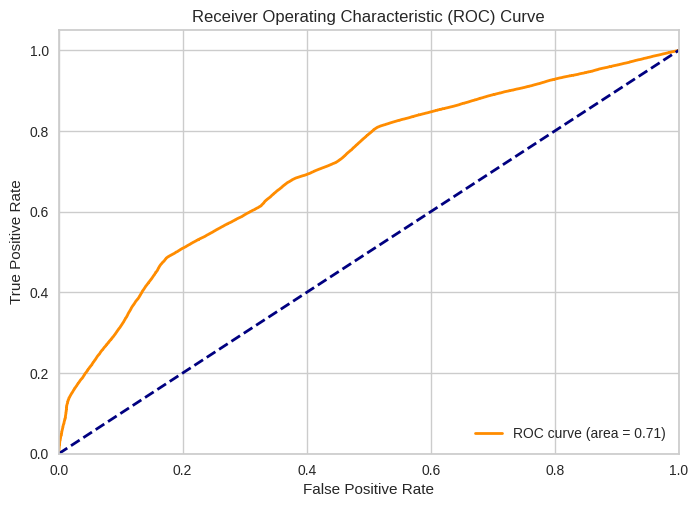

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = rf.predict_proba(X_test)[:, 1]

# Compute the ROC curve data
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Compute the AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## CatBoost

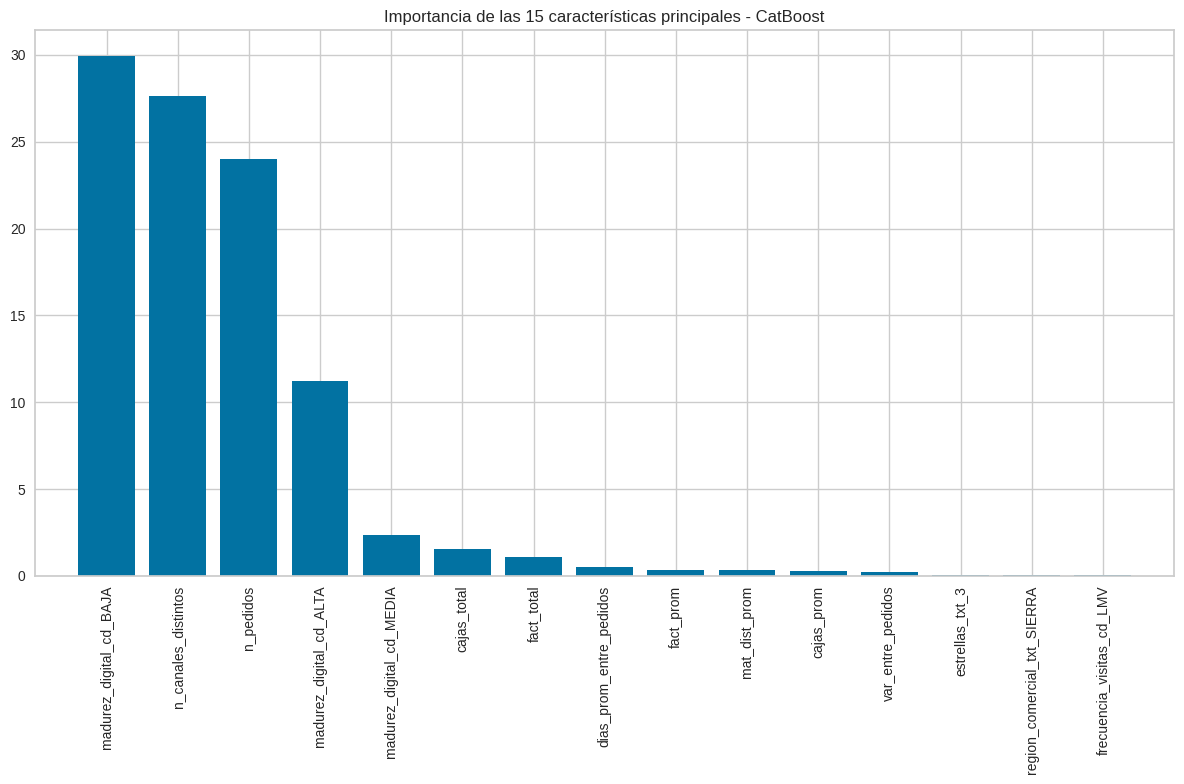

In [ ]:
from catboost import CatBoostClassifier, Pool
import numpy as np
import matplotlib.pyplot as plt

# Entrenar un modelo de CatBoost
cat = CatBoostClassifier(
    iterations=200,      # número de árboles
    depth=4,             # profundidad máxima
    learning_rate=0.1,
    random_seed=69,
    loss_function="Logloss",
    verbose=False        # silencia el entrenamiento
)

cat.fit(X_train, y_train)

# Importancia de características
importances = cat.get_feature_importance(Pool(X_train, y_train))
indices = np.argsort(importances)[::-1]

# Nombres de las características
feature_names = X_train.columns
sorted_feature_names = [feature_names[i] for i in indices]

# Seleccionar las 15 más importantes
top_n = 15
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_sorted_feature_names = [feature_names[i] for i in top_indices]

# Gráfico
plt.figure(figsize=(12, 8))
plt.title("Importancia de las 15 características principales - CatBoost")
plt.bar(range(top_n), top_importances, align="center")
plt.xticks(range(top_n), top_sorted_feature_names, rotation=90)
plt.xlim([-1, top_n])
plt.tight_layout()
plt.show()


In [ ]:
cat_predictions = cat.predict(X_test)
cat_accuracy = accuracy_score(y_test, cat_predictions)
print(f"rf Accuracy: {rf_accuracy:.4f}")

rf Accuracy: 0.6596


In [ ]:
report = classification_report(y_test, cat_predictions)
print("Reporte de clasificación:")
print(report)

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.64      0.58      0.61     48778
           1       0.73      0.78      0.76     72990

    accuracy                           0.70    121768
   macro avg       0.69      0.68      0.68    121768
weighted avg       0.70      0.70      0.70    121768



## Ensemble

Accuracy: 0.6925957558636094

Confusion Matrix:
 [[27667 21111]
 [16321 56669]]

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.57      0.60     48778
           1       0.73      0.78      0.75     72990

    accuracy                           0.69    121768
   macro avg       0.68      0.67      0.67    121768
weighted avg       0.69      0.69      0.69    121768



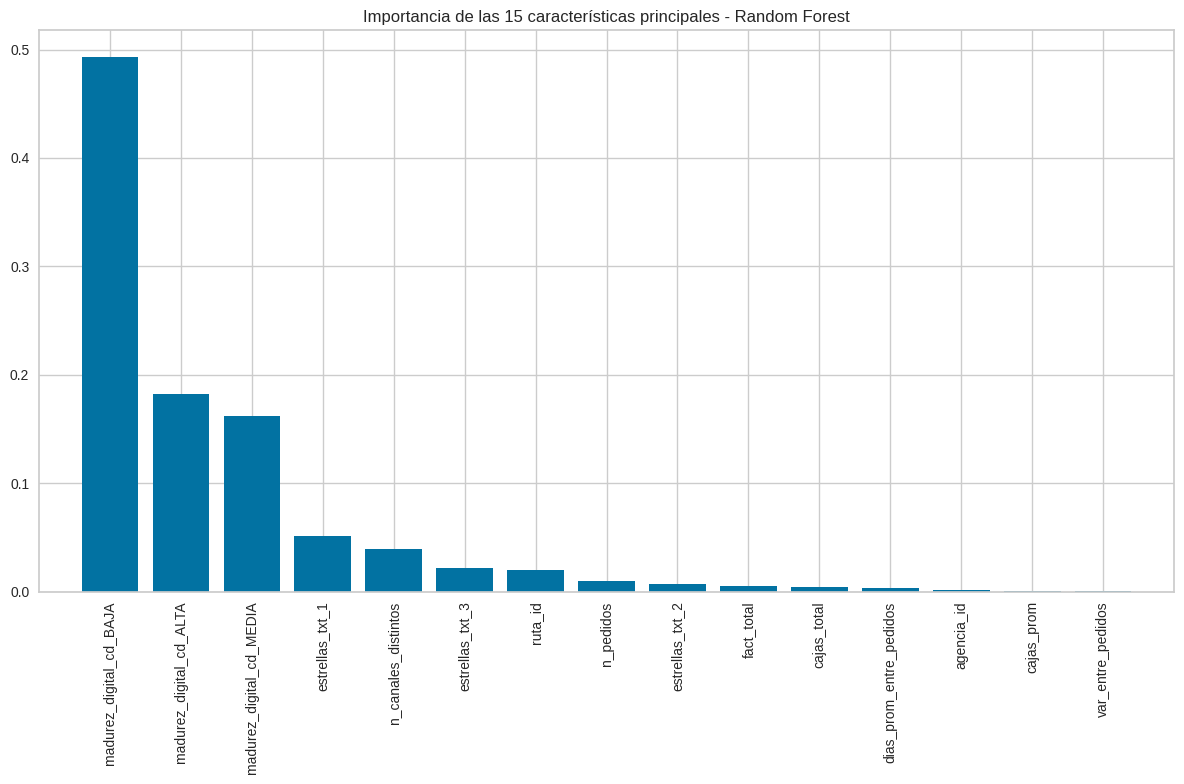

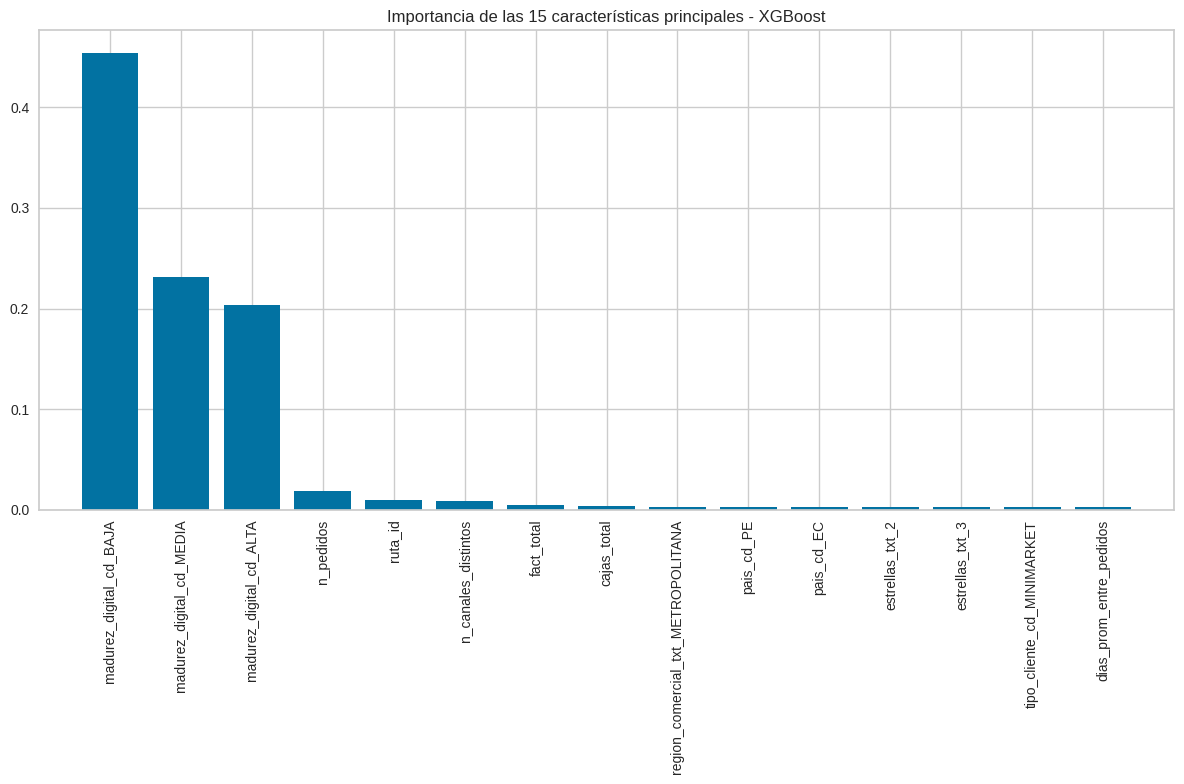

In [ ]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Modelos base
# =========================
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=4,
    random_state=69,
    n_jobs=-1,
    criterion="gini"
    # class_weight="balanced"  # <- opcional si hay desbalance de clases
)

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=69,
    eval_metric="logloss",
    use_label_encoder=False
)

# =========================
# Meta-learner (Logistic Regression)
# =========================
meta = LogisticRegression(
    max_iter=1000,
    random_state=69
    # class_weight="balanced"  # <- opcional si hay desbalance
)

# =========================
# Stacking Ensemble
# =========================
stack_model = StackingClassifier(
    estimators=[("rf", rf), ("xgb", xgb)],
    final_estimator=meta,
    stack_method="predict_proba",  # pasar probabilidades al meta-learner
    cv=5,
    n_jobs=-1
)

# =========================
# Entrenar
# =========================
stack_model.fit(X_train, y_train)

# =========================
# Evaluar
# =========================
y_pred = stack_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# =========================
# (Opcional) Validación cruzada sobre todo el dataset
# =========================
# scores = cross_val_score(stack_model, np.vstack([X_train, X_test]), np.hstack([y_train, y_test]),
#                          cv=5, scoring="accuracy", n_jobs=-1)
# print("Cross-val Accuracy mean:", np.mean(scores))

# =========================
# Importancias de características por modelo base
# =========================
feature_names = X_train.columns

# --- Random Forest ---
rf_fitted = stack_model.named_estimators_["rf"]
rf_importances = rf_fitted.feature_importances_
rf_indices = np.argsort(rf_importances)[::-1]
top_n = 15
rf_top_idx = rf_indices[:top_n]
rf_top_imp = rf_importances[rf_top_idx]
rf_top_names = [feature_names[i] for i in rf_top_idx]

plt.figure(figsize=(12, 8))
plt.title("Importancia de las 15 características principales - Random Forest")
plt.bar(range(top_n), rf_top_imp, align="center")
plt.xticks(range(top_n), rf_top_names, rotation=90)
plt.xlim([-1, top_n])
plt.tight_layout()
plt.show()

# --- XGBoost ---
xgb_fitted = stack_model.named_estimators_["xgb"]
xgb_importances = xgb_fitted.feature_importances_
xgb_indices = np.argsort(xgb_importances)[::-1]
xgb_top_idx = xgb_indices[:top_n]
xgb_top_imp = xgb_importances[xgb_top_idx]
xgb_top_names = [feature_names[i] for i in xgb_top_idx]

plt.figure(figsize=(12, 8))
plt.title("Importancia de las 15 características principales - XGBoost")
plt.bar(range(top_n), xgb_top_imp, align="center")
plt.xticks(range(top_n), xgb_top_names, rotation=90)
plt.xlim([-1, top_n])
plt.tight_layout()
plt.show()
